# Informe:

## Introducción

Datos: head y violinplots# Informe:

## Introducción

Datos: head y violinplots
Objetivo del tp e introducción a los modelos

## Métodos
Preparación de datos: sacar datos faltantes, creación de features nuevas y eliminar las categóricas

Separación en train y test: stratified split
Con el set de training hacemos validación: grid search para buscar best hiperparametros en cada modelo
Entrenamos cada modelo con el set de train y el mejor hiperparametro
Testeamos el modelo con el set de test

## Resultados y Discusión
Comparamos los diferentes modelos (ECM)
Discusión de cuál método ajusta mejor

# Introducción

La base de datos de \textit{California Housing Prices} corresponde a un censo del año 1990 en la provincia de California, Estados Unidos. Cada entrada (fila de la tabla) es un distrito. El objetivo de este trabajo práctico fue predecir el valor de la variable \textit{median\_housing\_price} utilizando el resto de las variables del dataset. La estimación se realizó utilizando una serie de modelos lineales con parámetros de regularización. Se utilizaron las regresiones de Lasso, Ridge y Elastic Net.

Importamos los paquetes necesarios

In [2]:
# Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

import numpy as np
import os
import seaborn as sns
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"


from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from zlib import crc32
import hashlib
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from six.moves import urllib
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
StratifiedKFold, GroupShuffleSplit,
GroupKFold, StratifiedShuffleSplit,cross_val_score)
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OrdinalEncoder,OneHotEncoder)

# Donde guardar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Cargamos los datos y miramos las 5 primeras entradas

In [3]:
housing = pd.read_csv("data/housing.csv");
housing.head();

# Exploración de los datos

La base de datos cuenta con 9 variables

In [4]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [30]:
housing.iloc[:,0]

0       -122.23
1       -122.22
2       -122.24
3       -122.25
4       -122.25
          ...  
20635   -121.09
20636   -121.21
20637   -121.22
20638   -121.32
20639   -121.24
Name: longitude, Length: 20640, dtype: float64

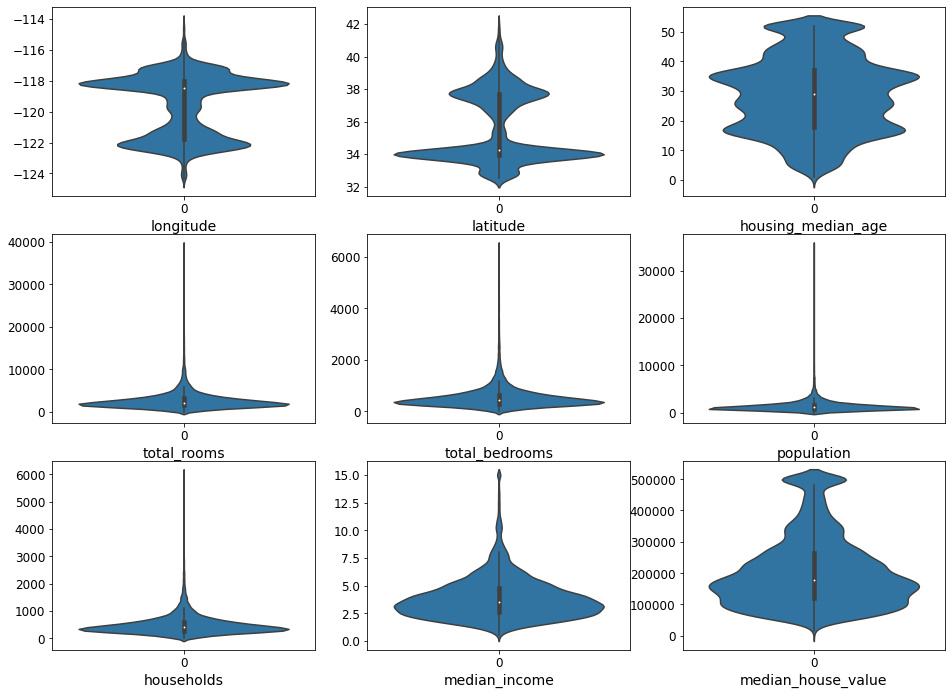

In [40]:
colnames = housing.columns
fig = plt.figure(figsize=(16,16))
for i in range(1, 10):
    ax = plt.subplot(4, 3, i)
    ax.set_xlabel(colnames[i-1])
    sns.violinplot(data=housing.iloc[:,i-1])

La tabla cuenta con datos de 20640 distritos. Como se puede obsevar en la tabla que sigue, la variable total_bedrooms posee 207 datos faltantes.

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Discretizamos la variable median_income en 5 categorías. Vemos que las proporciones categorías no son uniformes.

In [88]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f7682fd08b0>)

Saving figure california_housing_prices_plot


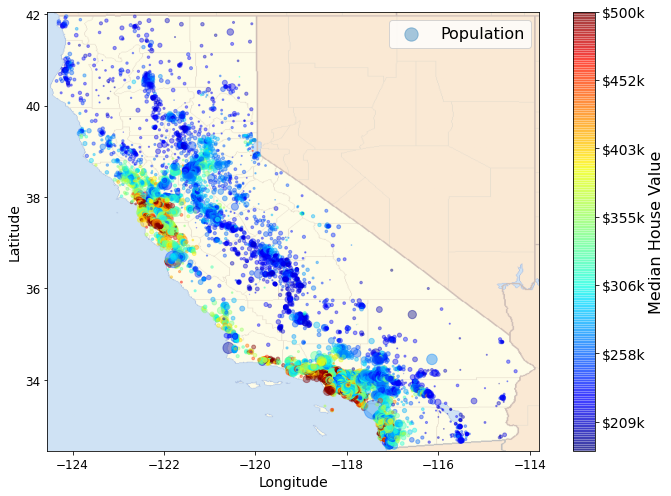

In [89]:

california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [5]:
#Gráfico alternativo con mapa
import plotly.graph_objects as go
df = housing

fig = go.Figure(data=go.Scattergeo(
        lon = df['longitude'],
        lat = df['latitude'],
        mode = 'markers',
        marker_color = df['median_house_value'],
        ))

fig.update_layout(
        title = 'Valor de propiedades según locación',
        geo_scope='usa'
        
    )
fig.show()

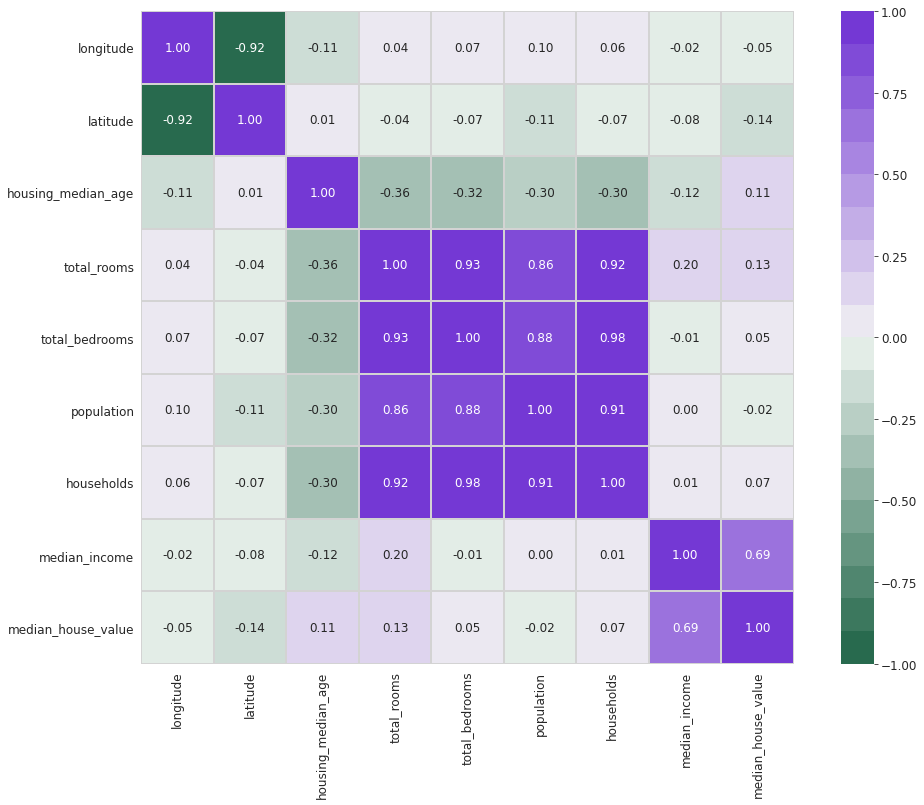

In [8]:
# Correlación entre variables preprocesamiento
corr_matrix = housing.corr()

paleta = sns.diverging_palette(150, 275, s=80, l=40, n=20)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(17, 12))
    ax = sns.heatmap(corr_matrix,
                     annot=True,
                     annot_kws={'size': 12},
                     fmt='.2f',
                     vmax=1, 
                     vmin=-1, 
                     square=True, 
                     linewidths=.01, 
                     linecolor='lightgray', 
                     cmap=paleta)

# Separación en train y test

Empleamos la estrategia de muestreo estratificado utilizando la variable median_income, para no incluir un sesgo en el muestreo. Dividimos las observaciones en subgrupos homogéneos llamados "strata". Este método garantiza que el set de test sea representativo de toda la población.

<AxesSubplot:>

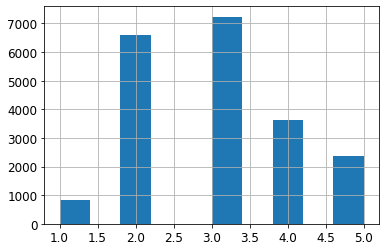

In [6]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

Comparamos las proporciones de la variable income_cat entre el data set completo, el set de testing resultado de un muestreo aleatorio y un muestreo estratificado. Vemos que el muestreo estratificado representa mejor las proporciones originales del set completo, por lo tanto elegimos este para realizar la división de datos.

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039729  0.040213      0.973236      -0.243309
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114583  0.109496     -4.318374       0.127011

# Procesamiento y limpieza de datos

In [22]:
#esto lo hacemos para que el pipeline funcione correctamente. Simplemente transforma el dataset en un ndArray
#para que luego pueda utilizarlo la transformacion con CombinedAttributesAdder
class ConvertToNDArray(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return None
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        return X.values

convert_toNdArray = ConvertToNDArray()

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True,rooms_ix=3, bedrooms_ix=4, population_ix=5, households_ix=6): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.rooms_ix = rooms_ix 
        self.bedrooms_ix=bedrooms_ix 
        self.population_ix=population_ix 
        self.households_ix=households_ix
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        rooms_per_household = X[:, self.rooms_ix] / X[:, self.households_ix]
        population_per_household = X[:, self.population_ix] / X[:, self.households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, self.bedrooms_ix] / X[:, self.rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [23]:
def processingData(dataSet, targetFeature, categoricalFeature, col_names, extra_attribs):
        #quitamos los nan
        dataSet_withoutnan = dataSet.dropna().copy()
        
        #dividimos el dataset en las variables que se usan en la prediccion y la variable a predecir
        data = dataSet_withoutnan.drop(targetFeature, axis=1).copy() # drop labels for training set
        data_labels = dataSet_withoutnan[targetFeature].copy()
        
        #procesamos primero los datos numericos
        print("procesando los datos numericos...\n")
        numerical_data = data.drop([categoricalFeature,"longitude", "latitude"], axis=1)
        
        #obtenemos los indices de las columnas que luego vamos a combinar
        rooms_ix, bedrooms_ix, population_ix, households_ix = [
            data.columns.get_loc(c) for c in col_names] # get the column indices
        
        #generamos el dataframe con los atributos extra
        attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
        data_extra_attribs = attr_adder.transform(data.values)
        
        data_extra_attribs = pd.DataFrame(
            data_extra_attribs,
            columns=list(data.columns)+extra_attribs,
            index=data.index)
            
        num_pipeline = Pipeline([
        ('convert_toNdArray', ConvertToNDArray()),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
        ])

        num_attribs = list(numerical_data)+extra_attribs
        
        #procesamos los datos categoricos
        print("procensando variables categoricas...\n")
        cat_attribs = [categoricalFeature]

        full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", OneHotEncoder(), cat_attribs),
            ])

        data_prepared = full_pipeline.fit_transform(data_extra_attribs)
        
        #devolvemos los datos procesados y los objetivos
        print("procesamiento finalizado :D")
        return data_prepared, data_labels

In [25]:
train, train_labels = processingData(strat_train_set, "median_house_value", 
                "ocean_proximity", 
                ["total_rooms", "total_bedrooms", "population", "households"], 
                ["rooms_per_household", "population_per_household","bedrooms_per_room"])

procesando los datos numericos...

procensando variables categoricas...

procesamiento finalizado :D


In [26]:
train.shape

(16354, 18)

In [40]:
test, test_labels = processingData(strat_test_set, "median_house_value", 
                "ocean_proximity", 
                ["total_rooms", "total_bedrooms", "population", "households"], 
                ["rooms_per_household", "population_per_household"])

procesando los datos numericos...

procensando variables categoricas...

procesamiento finalizado :D


# **Entrenamiento de los modelos**

In [41]:
def selectValuesForHyperparameter(initialValue, lastValue, jumps):
    rv = []
    for v in range(int(initialValue*100), int(lastValue*100),int(jumps*100)):
        rv.append(float(v/100));
    return rv 

In [42]:
alphaValues = selectValuesForHyperparameter(0.8, 10, 0.2)    
print(alphaValues)

[0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8]


## [**Lasso**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
Linear Model trained with L1 prior as regularizer (aka the Lasso)

The optimization objective for Lasso is:
$$(1 / (2 * n_{samples})) * ||y - Xw||^2_2 + \alpha * ||w||_1$$


## Búsqueda del mejor hiperparámetro

In [50]:
lasso_params = {'alpha':alphaValues}
lasso = linear_model.Lasso(max_iter=5000)
clf_lasso = GridSearchCV(lasso, lasso_params, cv=10,
                                scoring='neg_mean_squared_error', #-> este scoring lo sacamos del Hands' On 
                                return_train_score=True)
clf_lasso.fit(train, train_labels)
clf_lasso.best_params_        
#sorted(clf.cv_results_.keys())

probando con maxima cantidad de iteraciones :1000


/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5440914875654.258, tolerance: 19949120660.01658
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5421631189931.484, tolerance: 19671349418.769135
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5427080473362.648, tolerance: 19754226082.5009
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: C

probando con maxima cantidad de iteraciones :1500


/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5440789259022.664, tolerance: 19949120660.01658
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5421505605568.234, tolerance: 19671349418.769135
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5426954907176.195, tolerance: 19754226082.5009
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: C

probando con maxima cantidad de iteraciones :2000


/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5440663649818.422, tolerance: 19949120660.01658
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5421380029245.609, tolerance: 19671349418.769135
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5426829349284.961, tolerance: 19754226082.5009
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: C

{'alpha': 1.0}

In [94]:
clf_lasso.cv_results_["mean_train_score"]

array([-4.59641140e+09, -4.59641460e+09, -4.59641853e+09, -4.59642316e+09,
       -4.59642851e+09, -4.59643457e+09, -4.59644134e+09, -4.59644883e+09,
       -4.59645703e+09, -4.59646594e+09, -4.59647557e+09, -4.59648590e+09,
       -4.59649696e+09, -4.59650872e+09, -4.59652120e+09, -4.59653439e+09,
       -4.59654829e+09, -4.59656291e+09, -4.59657824e+09, -4.59659428e+09,
       -4.59661104e+09, -4.59662850e+09, -4.59664669e+09, -4.59666558e+09,
       -4.59668429e+09, -4.59670126e+09, -4.59671883e+09, -4.59673699e+09,
       -4.59675574e+09, -4.59677509e+09, -4.59679503e+09, -4.59681557e+09,
       -4.59683671e+09, -4.59685845e+09, -4.59688078e+09, -4.59690371e+09,
       -4.59692723e+09, -4.59695134e+09, -4.59697606e+09, -4.59700137e+09,
       -4.59702727e+09, -4.59705376e+09, -4.59708085e+09, -4.59710854e+09,
       -4.59713682e+09, -4.59716569e+09])

## Entrenamos el modelo con el hiperparámetro seleccionado

In [51]:
lasso = linear_model.LassoCV(alphas=[clf.best_params_['alpha']],
                               max_iter=5000, 
                               cv=10, 
                               random_state=0).fit(train, train_labels)

In [53]:
print("Los coeficientes resultantes del entrenamiento son :"+str(lasso.coef_)+'\n')
print("El termino de regularizacion resultante es :"+str(lasso.intercept_))

Los coeficientes resultantes del entrenamiento son :[ 15659.04621939  -8548.14182552  19112.32089297 -10624.95154425
  -6254.58827967  63071.04189633  20024.90817099   1133.97131072
   -253.39550063  15093.77040809   -644.39160509  28567.75658632
      0.         -68874.23445692 143504.46572524  -4393.12888509
   6220.52277821]

El termino de regularizacion resultante es :228727.10573663274


## Testingggggggggggggggggggggg

In [55]:
housing_predictions_lasso = lasso.predict(test)
lin_mse_lasso = mean_squared_error(test_labels, housing_predictions_lasso)
lin_rmse_lasso = np.sqrt(lin_mse_lasso)
lin_rmse_lasso

65776.55955190104

In [102]:
#parametro optimo encontrado es 1.0 con grid search 
len(housing_predictions_lasso)

4079

## [**Ridge**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) 
Linear least squares with l2 regularization.

Minimizes the objective function:
$$||y - Xw||^2_2 + \alpha * ||w||^2_2$$

## Búsqueda del mejor hiperparámetro

In [56]:
alphaValues = selectValuesForHyperparameter(1, 10, 0.1)    
ridge_params = {'alpha':alphaValues}
ridge = Ridge(max_iter=5000)
clf_ridge = GridSearchCV(ridge, ridge_params, cv=10,
                                    scoring='neg_mean_squared_error',
                                    return_train_score=True)
clf_ridge.fit(train, train_labels)
sorted(clf_ridge.cv_results_.keys())
clf_ridge.best_params_

{'alpha': 1.0}

In [57]:
clf_ridge.cv_results_["mean_train_score"]

array([-4.48467778e+09, -4.48472296e+09, -4.48476811e+09, -4.48481302e+09,
       -4.48485755e+09, -4.48490156e+09, -4.48494496e+09, -4.48498770e+09,
       -4.48502970e+09, -4.48507094e+09, -4.48511139e+09, -4.48515103e+09,
       -4.48518986e+09, -4.48522787e+09, -4.48526506e+09, -4.48530145e+09,
       -4.48533703e+09, -4.48537183e+09, -4.48540584e+09, -4.48543910e+09,
       -4.48547162e+09, -4.48550340e+09, -4.48553447e+09, -4.48556486e+09,
       -4.48559456e+09, -4.48562361e+09, -4.48565202e+09, -4.48567980e+09,
       -4.48570698e+09, -4.48573357e+09, -4.48575959e+09, -4.48578506e+09,
       -4.48580999e+09, -4.48583439e+09, -4.48585829e+09, -4.48588169e+09,
       -4.48590461e+09, -4.48592707e+09, -4.48594908e+09, -4.48597065e+09,
       -4.48599179e+09, -4.48601252e+09, -4.48603285e+09, -4.48605279e+09,
       -4.48607235e+09, -4.48609155e+09, -4.48611039e+09, -4.48612888e+09,
       -4.48614703e+09, -4.48616486e+09, -4.48618237e+09, -4.48619956e+09,
       -4.48621646e+09, -

## Entrenamos el modelo con el hiperparámetro seleccionado

In [58]:
ridge = linear_model.RidgeCV(alphas=[clf_ridge.best_params_['alpha']],
                             cv=10, 
                             scoring='neg_mean_squared_error')
ridge.fit(train, train_labels)


RidgeCV(alphas=array([1.]), cv=10, scoring='neg_mean_squared_error')

In [59]:
print("Los coeficientes resultantes del entrenamiento son :"+str(ridge.coef_))
print("El termino de regularizacion resultante es :"+str(ridge.intercept_))

Los coeficientes resultantes del entrenamiento son :[ 15666.70149366  -8562.11077082  19168.54799223 -10606.57464312
  -6308.24529365  62961.10723097  20099.61495475   1130.84909004
   -255.59633289  15083.1613671    -589.48798161  28569.23978754
  -7299.3894863  -76158.10213319  96229.22126471 -11700.9318469
  -1070.79779939]
El termino de regularizacion resultante es :236026.3360349962


## Testing goes brrrrrrrrrr

In [60]:
housing_predictions_ridge = ridge.predict(test)
lin_mse_ridge = mean_squared_error(test_labels, housing_predictions_ridge)
lin_rmse_ridge = np.sqrt(lin_mse_ridge)
lin_rmse_ridge

65801.19906127549

### [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

$$1 / (2 * n_{samples}) * ||y - Xw||^2_2 + \alpha * l_{1_{ratio}} * ||w||_1 + 0.5 * \alpha * (1 - l_{1_{ratio}}) * ||w||^2_2$$

## Búsqueda del mejor hiperparámetro

In [62]:
alphaValues = selectValuesForHyperparameter(0.2, 10, 0.2);  
l1Values = selectValuesForHyperparameter(0.05, 1, 0.05);  

elastic_params = {'alpha':alphaValues, 'l1_ratio':l1Values}
elastic = linear_model.ElasticNet(max_iter=5000)
clf_elastic = GridSearchCV(elastic, elastic_params, cv=10,
                                    scoring='neg_mean_squared_error', #-> este scoring lo sacamos del Hands' On 
                                    return_train_score=True)
clf_elastic.fit(train, train_labels)
sorted(clf_elastic.cv_results_.keys())
clf_elastic.best_params_

{'alpha': 0.2, 'l1_ratio': 0.95}

## Entrenamos el modelo con el hiperparámetro seleccionado

In [69]:
elastic = linear_model.ElasticNetCV(alphas=[clf_elastic.best_params_['alpha']],
                                  l1_ratio=[clf_elastic.best_params_['l1_ratio']],
                                  max_iter=5000,
                                  cv=10)
elastic.fit(train, train_labels)

ElasticNetCV(alphas=[0.2], cv=10, l1_ratio=[0.95], max_iter=5000)

In [70]:
print("Los coeficientes resultantes del entrenamiento son :"+str(elastic.coef_)+'\n')
print("El termino de regularizacion resultante es :"+str(elastic.intercept_))

Los coeficientes resultantes del entrenamiento son :[ 15873.24523521  -7964.48128399  13799.55562246  -9188.08801632
  -1640.63152351  51877.96841974  26966.68222269   1404.48689787
   -282.2135522   13411.97704737   4497.11371369  28463.41853433
  16187.9647071  -50545.03073984   1998.90230222  10991.51590509
  21309.63926337]

El termino de regularizacion resultante es :212106.05938455596


## Testing Cuchau

In [71]:
housing_predictions_elastic = elastic.predict(test)
lin_mse_elastic = mean_squared_error(test_labels, housing_predictions_elastic)
lin_rmse_elastic = np.sqrt(lin_mse_elastic)
lin_rmse_elastic

66101.03208781325

# Comparación de los RMSE

In [72]:
print("El RMSE para Elastic Net es:"+str(lin_rmse_elastic)+'\n')
print("El RMSE para Ridge es:"+str(lin_rmse_ridge)+'\n')
print("El RMSE para Lasso es:"+str(lin_rmse_lasso)+'\n')

El RMSE para Elastic Net es:66101.03208781325

El RMSE para Ridge es:65801.19906127549

El RMSE para Lasso es:65776.55955190104

